# Online DA: Perfect pseudo experiments validation: 
Katie Brennan  
January 27, 2022  

In [3]:
import sys
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs

import pickle 

In [4]:
sys.path.append("../")
import Online_DA_utils as oda

In [5]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
# import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [6]:
import importlib
importlib.reload(oda)
importlib.reload(limkb)

<module 'LIM_utils_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils_kb.py'>

In [7]:
limvars = ['tas','tos','psl','zg','sit','sic']

## Load experiment: 

In [39]:
output_dir = '/home/disk/kalman2/mkb22/Online_DA/experiments/pseudo/'

#timename = 'Time_'+str(t)+'.pkl'
#filename = 'ODA_pseudo_perfect_CESM_LME_t_0_1860.pkl'
filename = 'ODA_pseudo_imperfect_cesm_lme_Amon_obs_cmip6_mpi_hist_regridlme_Amon_t_0_1860_nomj_Re.pkl'

In [40]:
data_mpi = pickle.load(open(output_dir+filename,"rb"))

In [41]:
output_dir = '/home/disk/kalman2/mkb22/Online_DA/experiments/pseudo/'

#timename = 'Time_'+str(t)+'.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860.pkl'
filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_nomj_Re.pkl'

In [42]:
data_cesm = pickle.load(open(output_dir+filename,"rb"))

In [43]:
LIM = oda.load_L('cesm_lme_Amon')
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

### Decompress posterior: 

In [44]:
Xa_dcomp_cesm = np.zeros((LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0],data_cesm['Xa'].shape[0]))
nmodes = LIMd['E3_all'].shape[1]

Xa_dcomp_cesm = limkb.decompress_eof_separate_sic(data_cesm['Xa'].T,nmodes,LIMd['exp_setup']['nmodes_sic'],
                                                 LIMd['E3_all'],LIMd['E_sic'],LIMd['exp_setup']['limvars'],
                                                 LIMd['var_dict'],LIMd['W_all'],Weights=LIMd['exp_setup']['Weight'],
                                                 sic_separate=LIMd['exp_setup']['sic_separate'])

In [45]:
Xa_dcomp_all_cesm = {}

for var in limvars: 
    Xa_dcomp_all_cesm[var] = Xa_dcomp_cesm[LIMd['var_dict'][var]['var_inds'],:]

In [46]:
Xa_dcomp_all_cesm['tas'].shape

(6912, 1860)

In [47]:
Xa_dcomp_mpi = np.zeros((LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0],data_mpi['Xa'].shape[0]))
nmodes = LIMd['E3_all'].shape[1]

Xa_dcomp_mpi = limkb.decompress_eof_separate_sic(data_mpi['Xa'].T,nmodes,LIMd['exp_setup']['nmodes_sic'],
                                                 LIMd['E3_all'],LIMd['E_sic'],LIMd['exp_setup']['limvars'],
                                                 LIMd['var_dict'],LIMd['W_all'],Weights=LIMd['exp_setup']['Weight'],
                                                 sic_separate=LIMd['exp_setup']['sic_separate'])

In [48]:
Xa_dcomp_all_mpi = {}

for var in limvars: 
    Xa_dcomp_all_mpi[var] = Xa_dcomp_mpi[LIMd['var_dict'][var]['var_inds'],:]

In [49]:
def calc_tot_si_checks(var, areacell, units, lat, nlon, lat_cutoff=0.0): 
    """Calculates total NH sea ice area. 
    
    INPUTS: 
    var: sea ice concentration (ndof,ntime), (ndarray)
    areacell: grid cell area, 1D or 2D, (ndarray)
    units: string ('km^2' or 'm2')
    lat: 
    lat_cutoff
    
    OUTPUTS: 
    tot_nh_var
    """
    
    if len(areacell.shape)>1:
        areacell_1d = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
    else: 
        areacell_1d = areacell

    if units == 'm2':
        cellarea = (areacell_1d*1e-6)[:,np.newaxis]
    else: 
        cellarea = areacell_1d[:,np.newaxis]

    if len(var.shape)<=1:
        var_3d = np.reshape(var,(lat.shape[0],nlon))
    elif len(var.shape) ==2:     
        var_3d = np.reshape(var,(lat.shape[0],nlon,var.shape[1]))
    else: 
        var_3d = var

    if len(lat.shape)<=1:
        var_nh_3d = var_3d[(lat>0),:,:]
        test_var = var_nh_3d[np.isfinite(var_nh_3d)]
    elif len(lat.shape)>1:
        var_nh_3d = var_3d[(lat>0),:]
        test_var = var_nh_3d[np.isfinite(var_nh_3d)]

    if np.nanmax(test_var)>5:
        print('Max concentration is '+str(np.round(np.nanmax(test_var),2))+
              ' ...dividing concentration by 100.')
        Var = var/100.0
    else: 
        Var = var

    nh_var = Var*cellarea

    if len(lat.shape)<=1:
        if len(var.shape)<=1:
            nh_var_3d = np.reshape(nh_var,(lat.shape[0],nlon))
            lat_inds = np.where(lat>lat_cutoff)
            tot_nh_var = np.nansum(np.nansum(nh_var_3d[lat_inds,:].squeeze(),axis=0),axis=0)
        else:     
            nh_var_3d = np.reshape(nh_var,(lat.shape[0],nlon,var.shape[1]))
            lat_inds = np.where(lat>lat_cutoff)
            tot_nh_var = np.nansum(np.nansum(nh_var_3d[lat_inds,:,:].squeeze(),axis=0),axis=0)
    else:
        lat_1d = np.reshape(lat,(var.shape[0]))
        lat_inds = np.where(lat_1d>lat_cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
        
    return tot_nh_var

In [50]:
def arctic_mean(var, areacell, cutoff=0.0): 
    if len(areacell.shape)>1:
        areacell_1d = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
    else: 
        areacell_1d = areacell
        
    tot_nh_var = var*areacell_1d
    
    if len(lat.shape)<=1:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds,:],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds,:],axis=0),axis=0)
    else:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds],axis=0),axis=0)
    
    var_mn = tot_nh_var/wt_sum
    
    return var_mn

In [51]:
def global_mean(var, areacell): 
    """Assumes var is dimensions (nlat*nlon,time)
    """
    var_shape = len(var.shape)
    var_nan_mask = np.where(np.isnan(var),np.nan,1)
    
    if (var_shape<2)&(len(areacell.shape)>1): 
        areacell_1d = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
    elif (var_shape>1)&(len(areacell.shape)>1): 
        areacell_1d_temp = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
        areacell_1d = areacell_1d_temp[:,np.newaxis]
    elif (var_shape>1)&(len(areacell.shape)<=1): 
        areacell_1d = areacell[:,np.newaxis]
    else: 
        areacell_1d = areacell
        
    tot_nh_var = var*areacell_1d
    
    tot_var = np.nansum(tot_nh_var,axis=0)
    wt_sum = np.nansum(areacell_1d*var_nan_mask,axis=0)
    
    var_mn = tot_var/wt_sum
    
    return var_mn

In [52]:
def calc_total_var_forecast(var, forecast_anom, var_dict, areacell, 
                            areacell_dict, areawt_name, lat_cutoff=False):
    units = areacell_dict[var][areawt_name[var]]['units']

    if 'km' in units:
        acell = areacell[var]
    elif 'centi' in units: 
        print('changing cellarea units from '+
              str(areacell_dict[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-10)
        units = 'km^2'
    else: 
        print('changing cellarea units from '+
              str(areacell_dict[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-6)
        units = 'km^2'
        
    if var == 'sic':
        nlon = int(var_dict[var]['var_ndof']/var_dict[var]['lat'].shape[0])
        tot_var_forecast = statskb.calc_tot_si_checks(forecast_anom,acell,units,var_dict[var]['lat'],nlon,lat_cutoff=0.0)
    else: 
        tot_var_forecast = statskb.global_mean(forecast_anom,acell)
        
    return tot_var_forecast

In [53]:
def calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,areacell,areacell_dict,
                           areawt_name,LIMd,lat_cutoff=False,iplot=False):
    """
    """ 
    units = areacell_dict[var][areawt_name[var]]['units']

    if 'km' in units:
        acell = areacell[var]
    elif 'centi' in units: 
        print('changing cellarea units from '+
              str(areacell_dict[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-10)
        units = 'km^2'
    else: 
        print('changing cellarea units from '+
              str(areacell_dict[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-6)
        units = 'km^2'
        
    if var == 'sic':
        nlon = int(var_dict[var]['var_ndof']/var_dict[var]['lat'].shape[0])
        tot_var_forecast = statskb.calc_tot_si_checks(forecast_anom,acell,units,var_dict[var]['lat'],nlon,lat_cutoff=0.0)
        tot_var_truth = statskb.calc_tot_si_checks(truth_anom,acell,units,var_dict[var]['lat'],nlon,lat_cutoff=0.0)
    else: 
        tot_var_forecast = statskb.global_mean(forecast_anom,acell)
        tot_var_truth = statskb.global_mean(truth_anom,acell)
    
    
    if iplot==True: 
        time = var_dict[var]['time']
        ntime = tot_var_truth.shape[0]
        ttime = time.shape[0]
        
        plt.figure(figsize=(6,4))
        plt.plot(tot_var_truth,label='truth')
        plt.plot(tot_var_forecast,label='forecast')
        plt.xlim(0,20)
        plt.legend()
        plt.show()

    corr_tot = np.corrcoef(tot_var_truth,np.nan_to_num(tot_var_forecast))[0,1]
    ce_tot = oda.coefficient_efficiency(tot_var_truth,np.nan_to_num(tot_var_forecast))
    
     ## New error var calculations: 10/06/21
    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))
    gm_rmse = statskb.global_mean(rmse*forecast_nan_mask,acell)
    gsum_rmse = np.nansum(gm_rmse*forecast_nan_mask)
    
    return corr_tot, ce_tot, tot_var_forecast, tot_var_truth, gm_rmse, gsum_rmse, rmse

In [54]:
valid_dsource = 'cmip6_mpi_hist_regridlme_Amon'

fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names(valid_dsource)

In [55]:
import datetime

nyears = 155

# Generate times: 
t_total = nyears*12
years = int(1850+np.floor((t_total-1)/12))
time = np.array([datetime.datetime(y, m, 15) for y in np.arange(1850,1850+nyears,1) for m in np.arange(1,13,1)])

## Full field: pan-Arctic skill

In [56]:
full_names, areawt_name, month_names = limbuild.load_full_names(valid_dsource)

areacell_dict_all = {}
areacell = {}
for var in limvars:
    areacell_dict = {}
    areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic_valid, 
                                                            remove_climo=False, detrend=False, verbose=False, 
                                                            lat_cutoff=LIMd['exp_setup']['lat_cutoff'][var])

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40


In [57]:
tot_var_forecast_cesm = {}
tot_var_forecast_mpi = {}

for var in limvars: 
    print('Working on '+var)
    forecast_anom_cesm = Xa_dcomp_all_cesm[var]
    forecast_anom_mpi = Xa_dcomp_all_mpi[var]

    tot_var_forecast_cesm[var] = calc_total_var_forecast(var, forecast_anom_cesm, LIMd['var_dict'],
                                                            areacell,areacell_dict_all,
                                                            areawt_name,lat_cutoff=False)
    tot_var_forecast_mpi[var] = calc_total_var_forecast(var, forecast_anom_mpi, LIMd['var_dict'],
                                                           areacell,areacell_dict_all,
                                                           areawt_name,lat_cutoff=False)

Working on tas
changing cellarea units from m^2 to km^2
changing cellarea units from m^2 to km^2
Working on tos
changing cellarea units from m^2 to km^2
changing cellarea units from m^2 to km^2
Working on psl
changing cellarea units from m^2 to km^2
changing cellarea units from m^2 to km^2
Working on zg
changing cellarea units from m^2 to km^2
changing cellarea units from m^2 to km^2
Working on sit
changing cellarea units from m^2 to km^2
changing cellarea units from m^2 to km^2
Working on sic
changing cellarea units from m^2 to km^2
changing cellarea units from m^2 to km^2


Text(0, 0.5, 'Northern hemisphere mean')

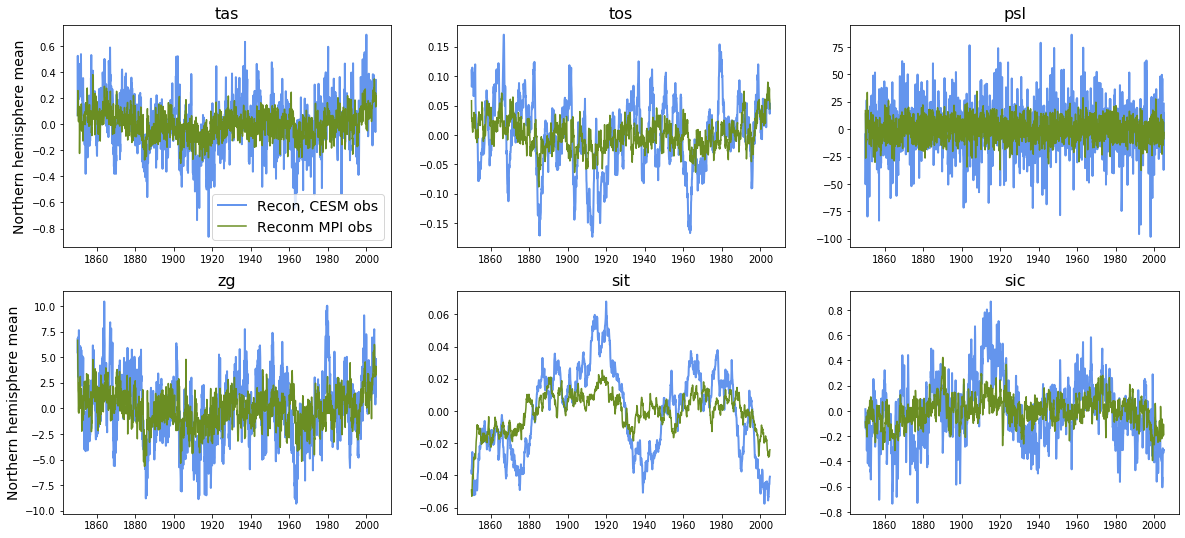

In [58]:
fig,axs = plt.subplots(2,3, figsize=(20,9))
ax = axs.flatten()

for i,var in enumerate(limvars):
    if 'sic' in var: 
        forecast_mpi = tot_var_forecast_mpi[var]*1e-6
        forecast_cesm = tot_var_forecast_cesm[var]*1e-6
    else: 
        forecast_mpi = tot_var_forecast_mpi[var]
        forecast_cesm = tot_var_forecast_cesm[var]
    
    ax[i].plot(time, forecast_cesm, label='Recon, CESM obs',color='cornflowerblue', linewidth=2)
    ax[i].plot(time, forecast_mpi, label='Reconm MPI obs', color='olivedrab')

    ax[i].set_title(var, fontsize=16)
#     ax[i].xticks(fontsize=14)
#     ax[i].yticks(fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('Northern hemisphere mean', fontsize=14)
ax[3].set_ylabel('Northern hemisphere mean', fontsize=14)

Text(0, 0.5, 'Northern hemisphere mean')

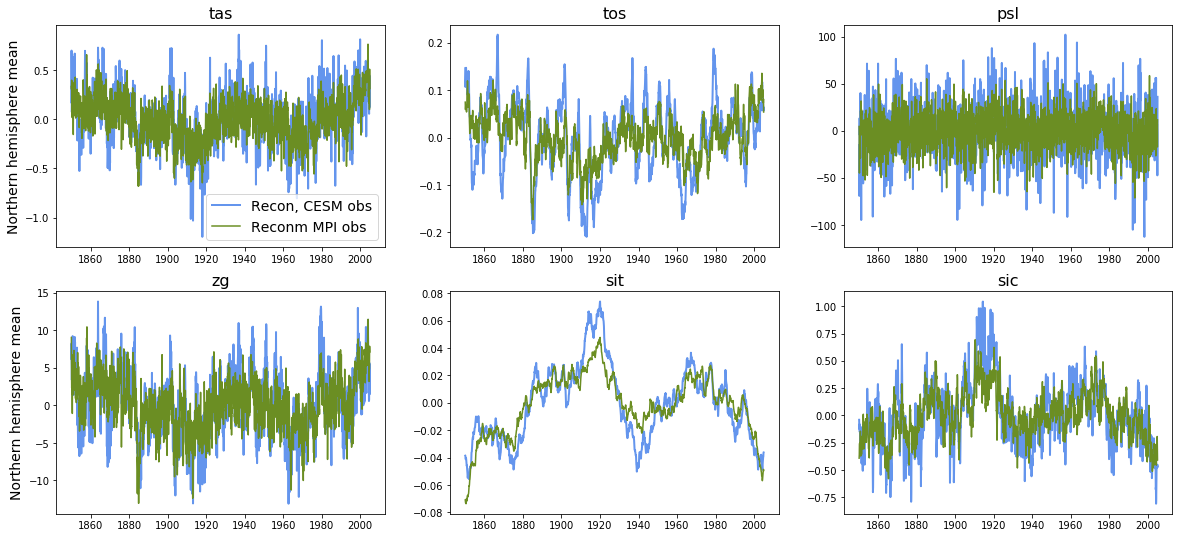

In [38]:
fig,axs = plt.subplots(2,3, figsize=(20,9))
ax = axs.flatten()

for i,var in enumerate(limvars):
    if 'sic' in var: 
        forecast_mpi = tot_var_forecast_mpi[var]*1e-6
        forecast_cesm = tot_var_forecast_cesm[var]*1e-6
    else: 
        forecast_mpi = tot_var_forecast_mpi[var]
        forecast_cesm = tot_var_forecast_cesm[var]
    
    ax[i].plot(time, forecast_cesm, label='Recon, CESM obs',color='cornflowerblue', linewidth=2)
    ax[i].plot(time, forecast_mpi, label='Reconm MPI obs', color='olivedrab')

    ax[i].set_title(var, fontsize=16)
#     ax[i].xticks(fontsize=14)
#     ax[i].yticks(fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('Northern hemisphere mean', fontsize=14)
ax[3].set_ylabel('Northern hemisphere mean', fontsize=14)

## Full field: Spatial skill: 

In [30]:
corr_all = {}
ce_all = {}

for var in limvars: 
    corr_var = np.zeros((Xa_dcomp_all[var].shape[0]))
    ce_var = np.zeros((Xa_dcomp_all[var].shape[0]))

    for i in range(Xa_dcomp_all[var].shape[0]):
        corr_var[i] = np.corrcoef(X_var_all[var][i,:],Xa_dcomp_all[var][i,:])[0,1]
        ce_var[i] = oda.coefficient_efficiency(X_var_all[var][i,:],Xa_dcomp_all[var][i,:])

    corr_var_2d = np.reshape(corr_var,(LIMd['var_dict'][var]['lat'].shape[0],LIMd['var_dict'][var]['lon'].shape[0]))
    ce_var_2d = np.reshape(ce_var,(LIMd['var_dict'][var]['lat'].shape[0],LIMd['var_dict'][var]['lon'].shape[0]))
    
    corr_all[var] = corr_var_2d
    ce_all[var] = ce_var_2d

../Online_DA_utils.py:88: RuntimeWarning: Mean of empty slice
  denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
../Online_DA_utils.py:89: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
../Online_DA_utils.py:89: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


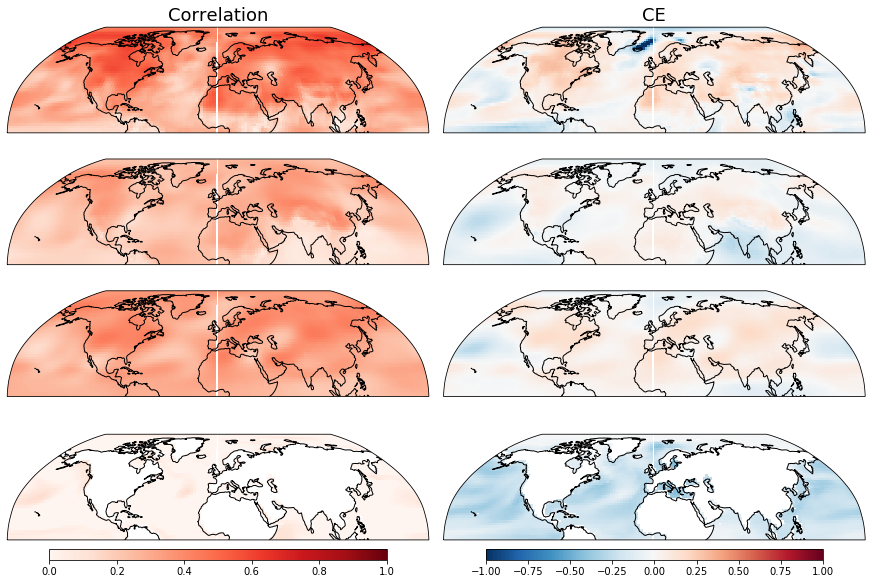

In [31]:
#fig = plt.figure(2, figsize=(14, 18))
fig,axs = plt.subplots(4,2, figsize=(12, 8), constrained_layout=True,
                       subplot_kw={'projection':ccrs.Robinson()})
ax = axs.flatten()
pltv = np.arange(0,8,2)

for v,var in enumerate(['tas','psl','zg','tos']): 
    lat = LIMd['var_dict'][var]['lat']
    lon = LIMd['var_dict'][var]['lon']
    
    i = pltv[v]
    ax[i].coastlines()
    cb1 = ax[i].pcolormesh(lon,lat,corr_all[var],
                   cmap='Reds',transform=ccrs.PlateCarree(),vmin=0, vmax=1)

    ax[i+1].coastlines()
    cb2 = ax[i+1].pcolormesh(lon,lat,ce_all[var],
                   cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1, vmax=1)

ax[0].set_title('Correlation', fontsize=18)
ax[1].set_title('CE', fontsize=18)

plt.colorbar(cb1, orientation='horizontal', shrink=0.8, ax=ax[6])
plt.colorbar(cb2, orientation='horizontal', shrink=0.8, ax=ax[7])

plt.tight_layout()

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


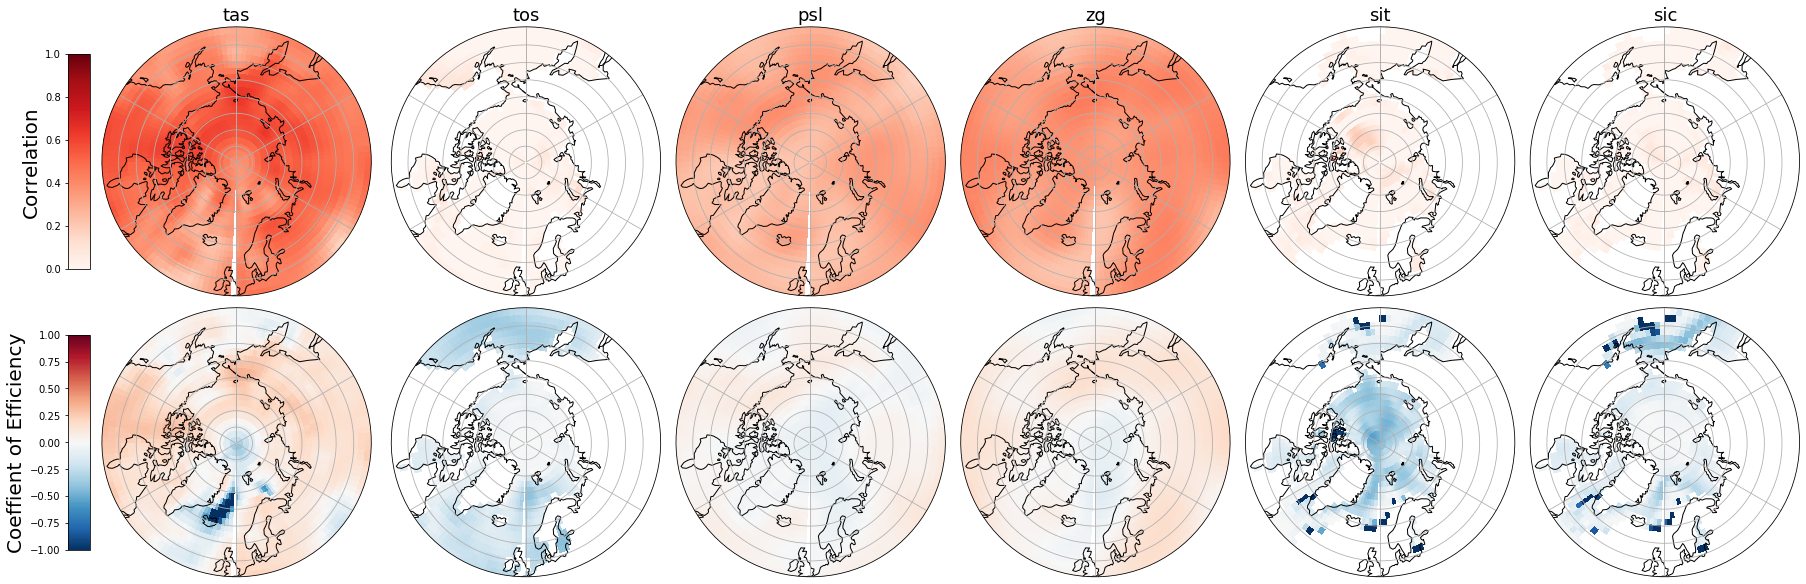

In [32]:
#fig = plt.figure(2, figsize=(14, 18))
fig,axs = plt.subplots(2,6, figsize=(25,8),constrained_layout=True,
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax = axs.flatten()
pltv = np.arange(6,12,1)

for v,var in enumerate(limvars):
    lat = LIMd['var_dict'][var]['lat']
    lon = LIMd['var_dict'][var]['lon']
    
    ax[v].coastlines()
    ax[v].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[v].set_boundary(circle, transform=ax[v].transAxes)
    ax[v].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb1 = ax[v].pcolormesh(lon,lat,corr_all[var],
                   cmap='Reds',transform=ccrs.PlateCarree(),vmin=0, vmax=1)
    i = pltv[v]
    ax[i].coastlines()
    ax[i].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb2 = ax[i].pcolormesh(lon,lat,ce_all[var],
                   cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1, vmax=1)
    
    ax[v].set_title(var, fontsize=18)


colb1 = fig.colorbar(cb1, location='left',shrink=0.8, ax=ax[0],aspect=30)
colb2 = plt.colorbar(cb2, location='left',shrink=0.8, ax=ax[6],aspect=30)

colb1.set_label(label='Correlation', size=20)
colb2.set_label(label='Coeffient of Efficiency', size=20)

plt.tight_layout()

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


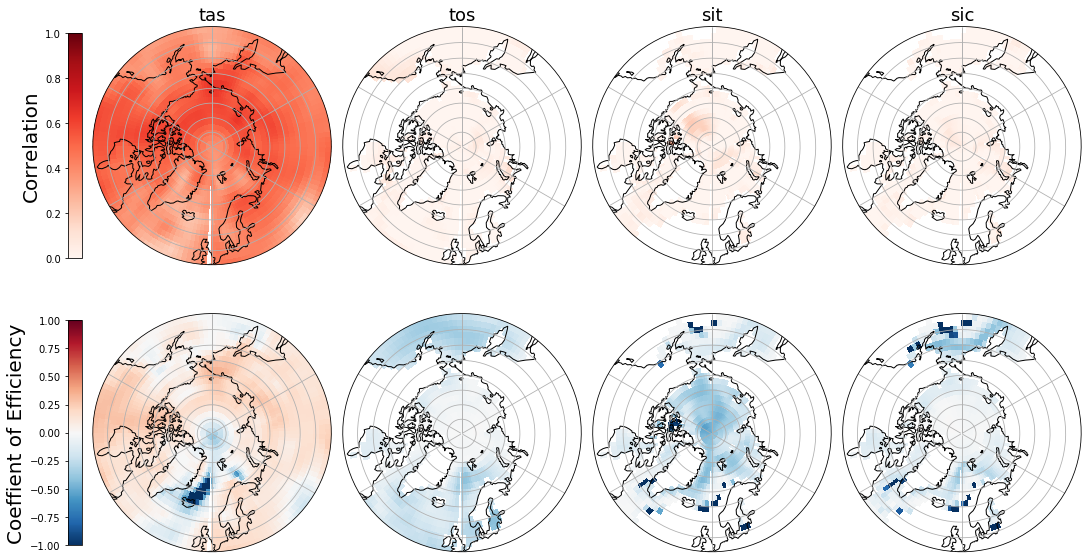

In [33]:
#fig = plt.figure(2, figsize=(14, 18))
fig,axs = plt.subplots(2,4, figsize=(15,8), constrained_layout=True,
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax = axs.flatten()
pltv = np.arange(4,8,1)

for v,var in enumerate(['tas','tos','sit','sic']):
    lat = LIMd['var_dict'][var]['lat']
    lon = LIMd['var_dict'][var]['lon']
    
    ax[v].coastlines()
    ax[v].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[v].set_boundary(circle, transform=ax[v].transAxes)
    ax[v].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb1 = ax[v].pcolormesh(lon,lat,corr_all[var],
                   cmap='Reds',transform=ccrs.PlateCarree(),vmin=0, vmax=1)
    i = pltv[v]
    ax[i].coastlines()
    ax[i].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb2 = ax[i].pcolormesh(lon,lat,ce_all[var],
                   cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1, vmax=1)
    
    ax[v].set_title(var, fontsize=18)


ax[0].set_ylabel('Correlation', fontsize=18)
# ax[1].set_title('CE', fontsize=18)

colb1 = fig.colorbar(cb1, location='left',shrink=0.8, ax=ax[0],aspect=30)
colb2 = plt.colorbar(cb2, location='left',shrink=0.8, ax=ax[4],aspect=30)

colb1.set_label(label='Correlation', size=20)
colb2.set_label(label='Coeffient of Efficiency', size=20)
#plt.tight_layout()